# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

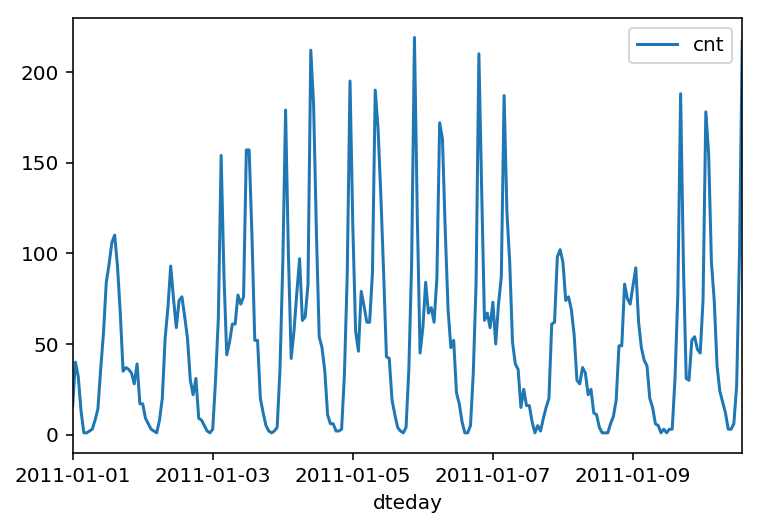

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [59]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        # self.activation_function = lambda x : 0  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        print(targets)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs
            
            #self.activation_function(final_inputs) # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            # TODO: Calculate the hidden layer's contribution to the error
            # hidden_error = np.dot(output_error_term, self.weights_hidden_to_output)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error * 1.0 #error * final_outputs * (targets - final_outputs)
            # hidden_error_term = None
            
            #hidden_error = error - hidden_outputs
            hidden_error = np.dot(self.weights_hidden_to_output, error)
            hidden_error_term = hidden_error * hidden_outputs * (1- hidden_outputs)
        
            #np.dot(output_error_term, self.weights_hidden_to_output) * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o #/ n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h #/ n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        # hidden_inputs = np.dot(self.input_nodes, self.weights_input_to_hidden) # signals into hidden layer
        hidden_inputs =  np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [60]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [61]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[ 0.4]]



----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [89]:
import sys

### Set the hyperparameters here ###
iterations = 100
learning_rate = 0.1
hidden_nodes = 2
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

7903    -0.768868
4900    -1.005929
2419     0.780301
1372    -0.642068
13629   -0.901181
8231    -0.123840
8780     0.576318
14847    0.774788
5096    -0.487702
6046     0.124247
12898    0.703118
1022    -0.465650
1420    -0.553859
11705   -0.090762
6138    -0.664120
8529    -1.027981
13460   -0.983877
7909    -0.912207
9234     0.311691
10117   -0.614502
10293   -0.570398
9851     0.102195
10429    1.304041
7144    -0.923233
8506    -1.033495
1879    -1.011442
4565    -1.011442
10504    0.896075
3637     0.802353
6582     0.388874
           ...   
9271    -0.912207
6198     0.350283
9163    -0.449111
10610   -0.857077
5881    -0.983877
2212    -0.972851
13893   -0.972851
4443    -0.752329
100     -0.410519
2086    -0.294745
542     -0.201023
14985    1.226858
5573    -1.022468
11680    0.074630
6765    -0.564885
12989    1.182754
2148    -0.173458
14543   -0.983877
14983    1.100058
2175    -0.835024
9986    -0.928746
9198    -1.033495
14660   -0.399493
1309    -0.344363
6523    -0

Progress: 6.0% ... Training loss: 136.8 ... Validation loss: 142.94964     0.603883
9604    -1.016955
2868    -0.873616
15303    1.386737
14431    0.940180
5866    -0.581424
14044    0.636961
2652    -0.355389
9755    -0.801946
12049   -0.289232
12844    0.234508
10702   -1.016955
14006    0.471570
13888    0.703118
7425    -0.680659
3829    -0.167945
8273     0.295152
3784     1.050441
4457     1.171728
12378   -0.570398
7096     0.085656
7195    -0.300258
4987     0.719657
880     -1.033495
14642    1.634825
12859   -0.669633
9284     1.066980
9079    -0.939773
2999    -0.184484
14908    0.570805
           ...   
9961    -0.835024
3823    -0.884642
5209    -0.631041
4222     0.791327
4151    -0.035631
4005     1.331607
455     -0.928746
6547     0.162839
244     -0.757842
13658   -0.625528
229     -0.636554
7055    -0.680659
10508   -0.790920
9276    -0.349876
4328    -0.956312
10243   -0.008066
5631    -0.807459
2715    -0.934260
3393     0.532213
1183    -0.416032
209     -1.01695

Progress: 13.0% ... Training loss: 1.083 ... Validation loss: 1.3676365     0.719657
2032    -0.504241
3466    -0.515267
9068     0.912614
11776    0.223482
13554   -0.416032
4659    -0.906694
10980    2.346009
5727    -0.906694
207     -0.961825
1059    -0.537319
5665     0.096682
8269    -0.901181
1190    -0.664120
5871    -1.033495
296     -0.498728
8431    -0.983877
6915     1.541103
5249    -0.063197
13975    0.692092
3879    -0.002553
4582     0.874023
8741    -1.016955
4242     0.736196
163     -0.956312
3143    -0.212049
4324    -0.697198
13093    1.326093
8306    -0.178971
7194     0.179378
           ...   
7745    -0.790920
7324    -0.212049
9168    -0.724763
2962    -0.570398
2643    -0.989390
1166    -0.730276
12950    2.103434
5610     0.846458
3867    -0.967338
8448    -0.046657
7471    -0.393980
13606   -1.000416
7977    -0.636554
9030    -1.033495
4264     0.625935
12702   -0.377441
14321    0.339256
5763     0.515674
12632    1.122110
7151     0.609396
5365    -0.2175

Progress: 20.0% ... Training loss: 0.974 ... Validation loss: 1.36712137    0.124247
8702    -0.713737
12049   -0.289232
3464    -0.961825
10838    2.015225
13365   -0.961825
7904    -0.934260
8868     0.030525
13038    0.063604
10815    0.835431
8450    -0.520780
9143    -0.664120
2929    -0.382954
7693    -1.005929
13754    1.640338
7394     1.629312
15208   -0.366415
7874     0.929153
10742    2.285365
4895     0.306178
4105    -0.096275
15259   -0.757842
10511   -1.000416
5365    -0.217562
2541     1.066980
12746    1.513537
11889   -0.030118
4206    -1.016955
14723    1.645851
445     -0.597963
           ...   
14616   -0.835024
11762    1.166215
6465    -0.686172
13538    1.276476
14938    0.670040
15304    0.725170
62      -0.178971
3719     0.069117
628     -0.691685
613     -0.553859
15293   -0.068710
4118     1.116597
12197    0.962232
11984    2.836671
9354     0.173865
9524     0.559779
6721    -0.796433
11952   -0.857077
8296    -0.719250
9027    -0.978364
6711    -0.9232

Progress: 27.0% ... Training loss: 0.974 ... Validation loss: 1.36713801   -0.145892
11625    0.289639
2906    -0.735789
14623   -0.289232
12478   -0.823998
14853   -0.553859
1037    -0.818485
1729     0.681066
10997   -0.057684
842     -0.691685
4380    -0.807459
9069     0.366822
12169   -0.923233
13702   -1.027981
12804    2.516914
11092    0.537726
12913    0.058091
2872    -0.454624
8138    -0.096275
9184    -0.708224
14461    3.658116
10421    2.390113
7354    -0.983877
12249    0.344770
6976    -0.928746
3183    -0.096275
11469   -0.730276
6809    -0.779894
10606   -0.768868
13946    1.574181
           ...   
7960    -0.697198
780     -0.873616
9986    -0.928746
8059    -0.768868
1086    -0.868103
9887    -0.912207
3228    -0.327823
1287    -0.526293
6499    -0.201023
15314    1.315067
3032    -0.498728
13326    1.375711
10014    0.499135
9249     0.273100
2380    -1.027981
12625   -0.212049
4094     0.063604
576     -0.879129
939     -0.085249
10376    0.162839
15367    1.1165

Progress: 34.0% ... Training loss: 0.974 ... Validation loss: 1.3676014    -1.000416
4391     0.284126
8543    -0.410519
11892    2.693331
3722    -0.785407
820     -0.041144
828     -0.879129
6581     0.846458
3716     1.485972
11528    0.317204
11761   -0.278206
1037    -0.818485
7769    -0.636554
11951   -0.983877
4049    -0.239614
6576     0.030525
10447   -0.052171
5314    -0.818485
10967   -0.890155
4952    -0.912207
15174    2.610636
2472    -0.658607
8655    -0.658607
7355    -1.039008
7319     0.719657
12782    1.706494
2258    -0.851564
540     -0.658607
9600    -0.581424
8941    -0.476676
           ...   
7976    -0.586937
7036     0.818892
13206    0.146299
4426     1.474946
7709    -0.344363
5925    -0.884642
4464     0.135273
6973    -1.011442
307     -0.658607
4684    -0.972851
14714    1.419815
8918    -0.388467
7372     0.488109
8785    -0.195510
6919    -0.338849
2261    -0.950799
14740    0.929153
15205    1.166215
11725    2.869749
15059    1.800216
4514    -0.9232

Name: cnt, dtype: float64
Progress: 41.0% ... Training loss: 0.974 ... Validation loss: 1.3674620     0.730683
2166    -1.022468
3292    -0.669633
4489    -0.647581
1830    -0.983877
1238    -0.068710
4824    -0.504241
14806   -0.967338
1977    -0.823998
9557    -1.039008
14000    2.092408
11325   -0.735789
14075    1.480459
5652    -0.691685
12671   -0.945286
10397    2.605122
3815    -0.272693
1498    -0.245127
4968     0.107708
1064    -1.011442
12356   -0.967338
6214     0.019499
2445    -0.653094
121     -0.520780
10022   -0.085249
12737    0.559779
2621    -0.912207
7860    -1.011442
13056   -0.851564
3088     0.002960
           ...   
3383     0.256561
4727     0.289639
4406    -0.101788
7977    -0.636554
13142    1.259937
14230   -1.027981
7526    -0.890155
855     -1.033495
1430    -0.658607
14026    2.136513
9665    -0.140379
9941    -0.592450
6143     1.028388
3721    -0.405006
2338     0.201430
13054   -1.033495
5114    -0.311284
8117    -0.272693
12351    0.686579
11794  

Progress: 48.0% ... Training loss: 0.974 ... Validation loss: 1.3672540     1.386737
3973     1.033902
11868    0.217969
4826    -0.857077
10477    2.731923
10360    1.414302
11470   -0.901181
6677     0.807866
5821    -0.509754
11884    0.912614
13520    2.406652
7633     0.537726
4245     1.463920
10029   -0.537319
7451    -0.790920
11155   -0.360902
6574     0.201430
13203    1.463920
4505    -0.239614
13146   -0.140379
2884    -1.016955
1855    -1.005929
1120    -0.460137
15188   -0.405006
13387   -0.752329
12181    1.811242
1474    -0.917720
11530    0.228995
8228    -0.250641
9572    -0.156919
           ...   
10419   -0.399493
15115   -0.686172
517     -0.686172
9080    -0.570398
382     -0.730276
9973     0.146299
4669    -0.267180
4748     1.061467
14918    0.741710
1610    -0.129353
8369     0.383361
6273    -0.228588
13831    1.971121
5350     0.526700
202     -0.702711
3917    -1.011442
5042    -0.807459
10759   -0.129353
4541    -1.022468
5642     1.331607
2115    -0.8295

Progress: 55.0% ... Training loss: 0.974 ... Validation loss: 1.36713606   -1.000416
4161     0.394387
5280     0.228995
2572    -0.994903
873     -0.735789
4307    -0.046657
5634    -0.912207
7       -1.027981
12019   -0.823998
5804    -0.879129
4562    -0.790920
9637     0.173865
8043     0.240021
39      -0.625528
10495    0.890562
2002    -0.311284
9678    -0.950799
11838    1.315067
7851     0.410926
3779     0.223482
13830    1.546616
5476    -0.691685
14234    1.816755
5609     0.328230
2882    -0.895668
12486    2.092408
3119    -0.719250
12911   -0.983877
13315    0.008473
4632     0.063604
           ...   
2474    -0.829511
1919     0.047064
8380    -0.234101
6830    -1.016955
272     -0.586937
9537     1.871886
9839    -0.741303
10012   -0.956312
13858    1.436355
1115    -1.027981
12330    0.267587
13127   -1.011442
5766     1.463920
6342     0.339256
9349    -0.498728
895     -0.559372
5674     0.069117
9269    -1.000416
14825    0.217969
8352     0.102195
960     -0.0852

Progress: 62.0% ... Training loss: 0.974 ... Validation loss: 1.3678470    -0.575911
2107     0.036038
3467    -0.206536
1673     0.510161
115     -0.983877
2184    -0.553859
13570    0.526700
4488    -0.256154
14916    0.818892
9943     1.541103
11467   -0.476676
5370     0.625935
10852    2.202669
5505     0.504648
1891    -0.586937
12608    0.521187
8169    -0.994903
114     -0.939773
14181   -0.388467
11758   -1.027981
8924     1.684442
11962    1.111084
5336    -0.548346
9719    -0.620015
1871     0.267587
3580    -0.978364
1668    -1.027981
2723    -0.035631
2038    -0.647581
13550    2.164078
           ...   
3285     0.614909
12993    1.210319
10560   -1.000416
927     -0.912207
9713     0.421952
8027    -1.027981
9014    -0.057684
14644    0.851971
1790    -0.967338
3727    -0.934260
3503    -0.223075
2903    -0.052171
6216    -0.057684
13395    2.599609
9441     0.201430
8196    -1.022468
4279    -0.967338
10319   -0.708224
11060   -0.879129
5207     0.223482
12665    0.4991

Progress: 69.0% ... Training loss: 0.974 ... Validation loss: 1.367922     -0.857077
6954    -0.112814
15076    1.210319
2826     0.438491
5880    -0.923233
59      -0.620015
12554    0.625935
4504    -0.305771
7863     0.840945
7635     0.102195
1244    -0.768868
12503   -0.989390
12754   -0.057684
4134    -0.983877
8928    -0.085249
3114     0.581831
5479    -1.000416
8028    -1.005929
3408    -0.052171
4592    -0.382954
9874    -0.570398
9051    -0.989390
4310     1.182754
3376    -0.118327
7278    -0.366415
11341   -0.829511
15085    3.487211
12604    0.923640
1902    -1.016955
1502    -0.923233
           ...   
553     -0.846051
11697    0.273100
7922     1.188267
2121    -0.862590
12654    2.075869
5913    -0.658607
12488    2.180617
9304     0.951206
15127    0.802353
4121     1.116597
717     -0.945286
9688    -0.189997
10804   -0.801946
10479    2.042791
6658    -0.752329
13126   -1.005929
4862    -0.234101
10636   -0.658607
7550    -0.972851
14111   -1.016955
6701     0.7086

Progress: 76.0% ... Training loss: 0.974 ... Validation loss: 1.3677980    -0.983877
9652    -0.967338
14802   -0.107301
1649    -0.559372
5377    -0.620015
9817    -0.636554
6222    -0.162432
3779     0.223482
3492     0.438491
9189     0.168352
13540    0.857484
6321    -0.608989
14228   -0.862590
12280    0.934666
7623    -0.978364
3866    -0.757842
11447   -1.011442
7298     0.796840
14347   -0.305771
4103     0.240021
11538   -0.713737
14007   -0.162432
13005   -0.548346
2627    -0.068710
2819    -0.096275
4446    -1.011442
4653     1.044928
9014    -0.057684
7648    -0.917720
60      -0.647581
           ...   
15412    1.061467
14493   -0.664120
10371   -0.421545
1850    -0.300258
9965    -0.972851
14456    0.554266
9983    -0.658607
11066    0.725170
7214    -0.895668
918     -0.427058
12307   -0.570398
5632    -0.917720
14767    0.896075
12586    0.504648
10516    0.907101
14009   -0.118327
6528    -0.035631
14750    2.241261
14964    4.336222
11968    0.377848
14666   -0.5924

Progress: 83.0% ... Training loss: 0.974 ... Validation loss: 1.3678154     0.025012
3162     0.201430
14215    0.510161
12352    0.311691
6450    -0.675146
14415    1.353659
544     -0.597963
12691   -0.823998
3531    -0.950799
12398    1.783677
3955     1.430842
11589   -0.950799
5655    -0.972851
13302    0.543240
574     -1.039008
14363   -0.090762
3838     0.780301
2081    -0.564885
3782     0.868510
2096    -1.016955
4509     1.011849
6333    -0.167945
6023    -0.030118
9632    -0.939773
2847     0.025012
10310    1.105571
5902    -0.504241
2036    -0.405006
5607     0.262074
1272    -1.033495
           ...   
302     -1.016955
2294     0.069117
4079     0.245534
9069     0.366822
5972     0.206943
7268    -0.151406
13969   -0.801946
11740    0.747223
13415   -1.011442
9438    -1.033495
5464     1.022875
6206    -1.005929
6899    -1.022468
1761    -0.906694
13324    0.510161
1283    -0.134866
11177   -0.305771
5859    -0.553859
14272    0.890562
10776   -1.005929
6333    -0.1679

Progress: 90.0% ... Training loss: 0.974 ... Validation loss: 1.36710932    1.171728
1051    -0.531806
11992    0.383361
4646     1.270963
5925    -0.884642
12157    1.243398
13665    1.678929
817     -0.085249
2691    -0.950799
6020    -0.300258
9335    -0.664120
101     -0.730276
1114    -1.027981
14932    0.951206
11622    0.377848
952     -0.983877
5836     0.350283
3905    -0.167945
8435    -1.022468
1421    -0.509754
2873    -0.333336
5185    -0.647581
15075    3.393489
8116    -0.217562
289     -0.757842
9442     1.386737
5626    -0.625528
13289    0.708631
10972   -0.366415
14526    1.651364
           ...   
728      0.002960
8481    -1.022468
1929    -1.011442
11398   -1.027981
6081    -0.664120
6115    -0.068710
5143    -1.016955
13550    2.164078
6627     1.122110
9200    -0.553859
276     -0.934260
3792     0.002960
11441   -0.035631
912     -0.702711
9955    -0.123840
10724   -0.691685
2666    -0.895668
13967   -1.005929
6355     0.019499
12803    1.050441
10112   -0.3167

Name: cnt, dtype: float64
Progress: 97.0% ... Training loss: 0.974 ... Validation loss: 1.36715089   -0.008066
627     -0.741303
6852    -1.016955
2686     0.245534
10329    1.215832
4023     0.096682
14024    1.949069
7741    -1.033495
5543     0.118734
12114   -0.123840
3686    -0.035631
14201   -0.735789
12656    2.357035
3327     0.080143
7002     0.030525
9248    -0.559372
3211     2.070356
10045   -0.305771
14074    0.515674
9577    -0.901181
11908    0.868510
9901    -0.068710
7984    -0.741303
14634   -0.112814
15383   -1.005929
15160    0.262074
12355   -0.774381
1871     0.267587
3521    -0.079736
5710     0.300665
           ...   
10883    0.697605
4541    -1.022468
3148    -0.972851
140     -1.039008
11518   -1.022468
12024   -0.961825
15264   -0.857077
7811    -0.873616
10895   -1.027981
13719    1.502511
2263    -1.027981
13706    1.541103
10329    1.215832
10975    1.684442
4447    -0.961825
6923    -0.945286
13545    0.449518
10065   -0.989390
1284    -0.101788
4665   

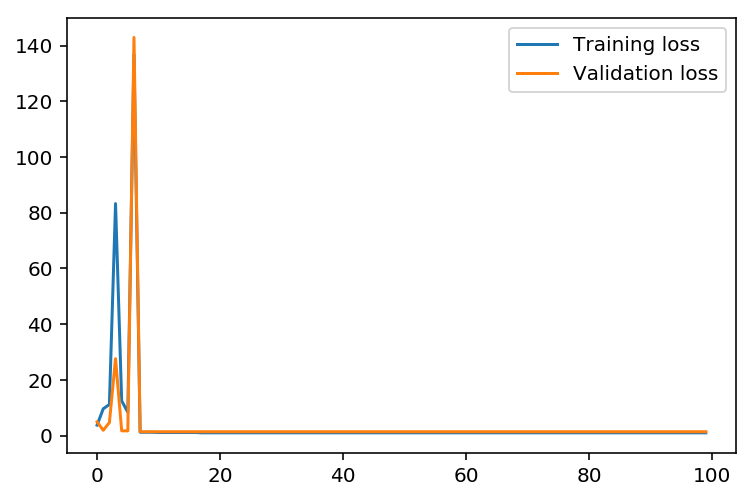

In [90]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

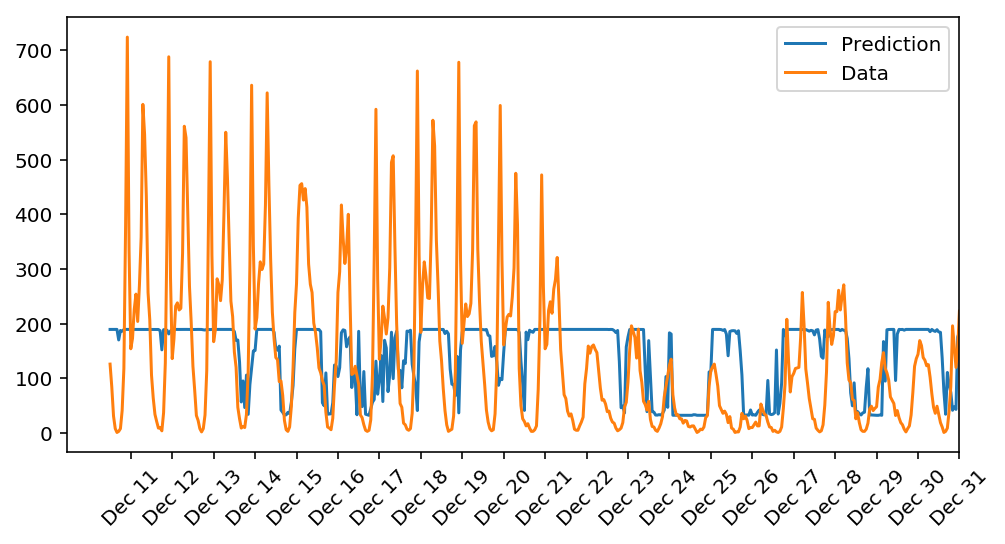

In [88]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below